In [1]:
%matplotlib inline

import torch

from torch.autograd import Variable
from torch.nn.init import xavier_normal

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [2]:
BATCH_SIZE = 128

transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [3]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size=500, coding_size=20):
        super(VAE, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2_mean = nn.Linear(hidden_size, coding_size)
        self.hidden2_gamma = nn.Linear(hidden_size, coding_size)
        self.hidden3 = nn.Linear(coding_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def encoder(self, x):
        hidden1_output = self.relu(self.hidden1(x))
        return self.hidden2_mean(hidden1_output), self.hidden2_gamma(hidden1_output)

    def reparameterize(self, mu, logvar):
        if self.training:
            noise = Variable(logvar.data.new(logvar.size()).normal_())
            return mu + torch.exp(0.5 * logvar) * noise
        else:
            return mu
    
    def decoder(self, x):
        output_value = self.relu(self.hidden3(x))
        output_value = self.output(output_value)
        return output_value, self.sigmoid(output_value)
            
    def forward(self, x):
        mean, gamma = self.encoder(x)
        z = self.reparameterize(mean, gamma)
        output, output_sigmoid = self.decoder(z)
        return output, output_sigmoid, mean, gamma

In [4]:
vae = VAE(input_size=28*28)

In [5]:
def custom_loss(recon_x, x, mu, logvar):
    ce_loss = F.binary_cross_entropy_with_logits(recon_x, x,
                                                size_average=False)
    latent_loss = 0.5 * torch.sum(torch.exp(logvar) + mu.pow(2) - 1 - logvar)
    return ce_loss + latent_loss

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [6]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [41]:
N_EPOCHS = 100
total_loss = 0
print_every = 70000 // BATCH_SIZE
plot_every = 7000 // BATCH_SIZE
all_losses = []
iter = 1

start = time.time()
vae.train()

for e in range(N_EPOCHS):
    for i_batch, batch in enumerate(trainloader):
        image = batch[0]
        label = batch[1]
        image = Variable(image.view(-1, 1, 28*28))
        
        vae.zero_grad()
        output, output_sigmoid, mean, gamma = vae(image)
        loss = custom_loss(output, image, mean, gamma)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(trainloader) * N_EPOCHS) * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / (plot_every*BATCH_SIZE))
            total_loss = 0
        
        iter = iter + 1

0m 16s (546 1%) 12636.4326
0m 35s (1092 2%) 13193.9141
0m 53s (1638 3%) 12776.1416
1m 12s (2184 4%) 12651.4961
1m 31s (2730 5%) 12730.7471
1m 49s (3276 6%) 12981.0322
2m 8s (3822 8%) 12672.7051
2m 26s (4368 9%) 12500.4512
2m 45s (4914 10%) 12208.4082
3m 4s (5460 11%) 12764.8369
3m 22s (6006 12%) 12972.2920
3m 41s (6552 13%) 12322.8955
4m 0s (7098 15%) 12672.5049
4m 18s (7644 16%) 12874.8828
4m 37s (8190 17%) 12554.6738
4m 56s (8736 18%) 12816.2793
5m 15s (9282 19%) 12842.8545
5m 34s (9828 20%) 12393.1621
5m 52s (10374 22%) 12635.1514
6m 11s (10920 23%) 12685.7588
6m 30s (11466 24%) 12405.2959
6m 49s (12012 25%) 13202.8486
7m 8s (12558 26%) 12351.6152
7m 27s (13104 27%) 13038.8633
7m 46s (13650 29%) 12547.7539
8m 5s (14196 30%) 12741.3809
8m 24s (14742 31%) 12773.6992
8m 42s (15288 32%) 12515.4971
9m 1s (15834 33%) 13017.8926
9m 20s (16380 34%) 12884.1084
9m 39s (16926 36%) 12404.4473
9m 58s (17472 37%) 12743.9873
10m 17s (18018 38%) 13111.2822
10m 36s (18564 39%) 12622.3857
10m 54s (19

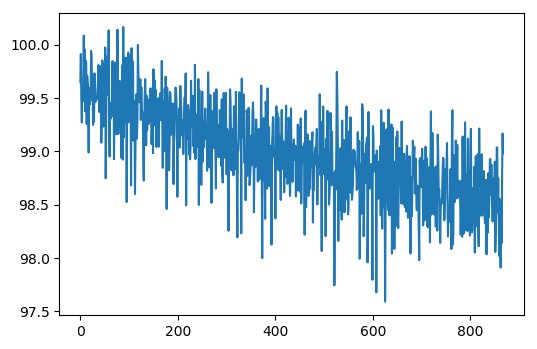

In [42]:
plt.plot(all_losses)

## Visualizing Features

In [43]:
hidden1_weights = vae.hidden1.weight.data.cpu().numpy()

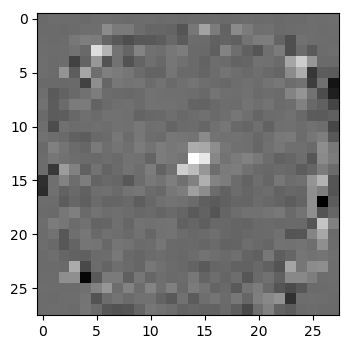

In [44]:
neuron = 0
plt.imshow(hidden1_weights[neuron].reshape([28,28]),
           cmap='Greys')

## Generating Images

In [45]:
vae.eval()
random = Variable(torch.randn(64, 20))
_, sample = vae.decoder(random)

In [46]:
sample.size()

torch.Size([64, 784])

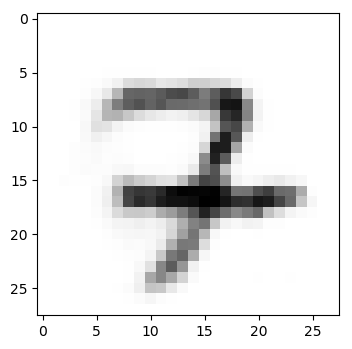

In [54]:
plt.imshow(sample[58].data.numpy().reshape(28,28),cmap="Greys")